In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from shogun import *
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [9]:
query = \
"""
set search_path to mimiciii;

-- Staging table #1: CHARTEVENTS
with ce_stg as
(
  select ie.subject_id, ie.hadm_id, ie.icustay_id, EXTRACT('epoch' from chart.charttime - ie.intime) / 60.0 / 60.0 as timestamp_hours
  , case
      when itemid in (211,220045) and chart.valuenum > 0 and chart.valuenum < 300 then 1 -- HeartRate
      else null end as vitalid
  , case
      when chart.itemid = any (ARRAY[223761, 678]) then (chart.valuenum - 32::double precision) / 1.8::double precision
      else chart.valuenum end as valuenum

  from icustays ie
  left join chartevents chart
    on ie.subject_id = chart.subject_id and ie.hadm_id = chart.hadm_id and ie.icustay_id = chart.icustay_id
    and chart.charttime >= ie.intime and chart.charttime <= (ie.intime + '1 day'::interval day)
    and chart.error is distinct from 1
    where chart.itemid = any
    (array[
    -- HEART RATE
    211, --"Heart Rate"
    220045 --"Heart Rate"
    ])
)
-- Aggregate table #1: CHARTEVENTS
, ce as
(
  SELECT ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id, ce_stg.timestamp_hours
  , case when VitalID = 1 then valuenum else null end as HeartRate
  FROM ce_stg
  group by ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id, ce_stg.vitalid, ce_stg.valuenum, ce_stg.timestamp_hours
  order by ce_stg.subject_id, ce_stg.hadm_id, ce_stg.icustay_id
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '12 hour' THEN 1 
    ELSE 0 END as hospital12hours_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' day THEN 1 
    ELSE 0 END as hospital1day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '7' day THEN 1 
    ELSE 0 END as hospital1week_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital1month_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #3: Services
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)


SELECT ie.icustay_id, ie.subject_id, ie.hadm_id
, co.age_icu_in, co.first_careunit, co.gender
, HeartRate, ce.timestamp_hours

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
-- , co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, co.hospital1month_expire_flag, co.hospital1week_expire_flag
, co.hospital12hours_expire_flag

FROM icustays ie
inner join admissions adm
  on ie.hadm_id = adm.hadm_id
inner join patients pat
  on ie.subject_id = pat.subject_id
left join ce
  on ie.icustay_id = ce.icustay_id
left join co
  on ie.icustay_id = co.icustay_id
left join excl
  on ie.icustay_id = excl.icustay_id

"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,age_icu_in,first_careunit,gender,heartrate,timestamp_hours,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital1month_expire_flag,hospital1week_expire_flag,hospital12hours_expire_flag
0,293212,82,110641,0.002693,NICU,M,156.0,8.395,0,0,0,0,0,0
1,293212,82,110641,0.002693,NICU,M,154.0,15.895,0,0,0,0,0,0
2,293212,82,110641,0.002693,NICU,M,153.0,7.395,0,0,0,0,0,0
3,293212,82,110641,0.002693,NICU,M,148.0,4.395,0,0,0,0,0,0
4,293212,82,110641,0.002693,NICU,M,148.0,1.395,0,0,0,0,0,0


In [11]:
# query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']


feature_names = [
            # Demographic information
            'age_icu_in', 'subject_id'
    
            # Vital signs
            'heartrate', 'timestamp', 
                 
            ]

query_output = query_output.loc[:, mortality_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

AttributeError: 'DataFrame' object has no attribute 'exclusion_los'

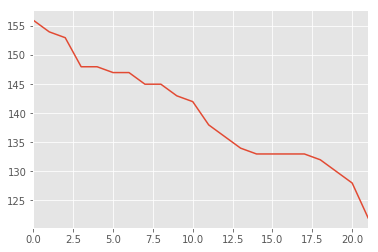

In [6]:
query_output.loc[query_output.subject_id == 82].heartrate.plot()

In [25]:
query_output.age_icu_in.min()

16.016350720599998